# Preprocesamiento de los Datos - Coffee Quality Database

Este notebook contiene el preprocesamiento realizado en el dataset de calidad del café del Coffee Quality Institute (CQI).

## Objetivos:
1. Utilizar los conocimientos obtenidos en el analisis previo
2. Analizar los tratamientos viables de los datos y sus efectos
3. Reducir la dimensionalidad del dataset en la medida de lo posible
4. Reducir la cantidad de datos faltantes
5. Eliminar las muestras que no aporten suficiente informacion
6. Acondicionar las variables no numericas
7. Normalizar las escalas de las variables numericas

**Autor:** Ricardo Contreras, Daniel Leon, Santiago Graciano  
**Fecha:** Octubre 2025

## 1. Carga de Datos

In [1]:
# Importaciones estándar
import sys
from pathlib import Path
import warnings

# Análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Agregar src al path para imports
project_root = Path.cwd().parent
print(project_root)
sys.path.append(str(project_root / 'src'))

print("✓ Librerías importadas correctamente")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

e:\dev\python\modelos_2
✓ Librerías importadas correctamente
✓ Pandas version: 2.3.3
✓ NumPy version: 2.3.4


In [110]:
# Rutas a los datos
data_path = project_root / 'data' / 'raw'

print(f"✓ Ruta de datos establecida en: {data_path}")
# Cargar datasets
arabica_df = pd.read_csv(data_path / 'arabica_data_cleaned.csv', index_col=0)
robusta_df = pd.read_csv(data_path / 'robusta_data_cleaned.csv', index_col=0)
merged_df= pd.read_csv(data_path / 'merged_data_cleaned.csv', index_col=0)

print(f"✓ Dataset Arábica cargado: {arabica_df.shape}")
print(f"✓ Dataset Robusta cargado: {robusta_df.shape}")
print(f"✓ Dataset Merged cargado: {merged_df.shape}")

✓ Ruta de datos establecida en: e:\dev\python\modelos_2\data\raw
✓ Dataset Arábica cargado: (1311, 43)
✓ Dataset Robusta cargado: (28, 43)
✓ Dataset Merged cargado: (1339, 43)


## 2. Limpieza de Datos

### 2.1 Eliminacion de muestras

Analizando el numero de muestras con valores nulos se decidio seguir el principio de Paretto, donde eliminamos todas las muestras que tuvieran mas del 20% de las columnas faltantes.

In [111]:
merged_df.shape

(1339, 43)

In [112]:
# Calcular el porcentaje de valores faltantes por muestra (fila)
missing_per_sample = merged_df.isnull().sum(axis=1)
missing_pct_per_sample = (missing_per_sample / merged_df.shape[1]) * 100

# Crear un DataFrame con la información de muestras y sus datos faltantes
samples_missing_info = pd.DataFrame({
    'Missing_Count': missing_per_sample,
    'Missing_Percentage': missing_pct_per_sample
})

# Ordenar por cantidad de valores faltantes (descendente)
samples_missing_info = samples_missing_info.sort_values('Missing_Count', ascending=False)

# Definir umbral para "muchos datos faltantes" (ej: más del 30%)
threshold = 20
samples_low_missing = samples_missing_info[samples_missing_info['Missing_Percentage'] > threshold]

samples_low_missing

,Missing_Count,Missing_Percentage
1197,15,34.883721
1138,14,32.558140
373,14,32.558140
1067,14,32.558140
414,14,32.558140
...,...,...
876,9,20.930233
264,9,20.930233
183,9,20.930233
909,9,20.930233


In [113]:
merged_df = merged_df.drop(index=samples_low_missing.index)
merged_df.shape

(1234, 43)

### 2.1 Eliminacion de variables (>70% Nulos)

In [114]:
missing_data = merged_df.isnull().sum()
missing_percent = (missing_data / len(merged_df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_data,
    'Porcentaje': missing_percent
}).sort_values(by='Porcentaje', ascending=False)

In [115]:
threshold = 70
columns_to_drop = missing_df[missing_df['Porcentaje'] > threshold].index
merged_df = merged_df.drop(columns=columns_to_drop)

print(f"Columnas eliminadas: {len(columns_to_drop)}")
print(f"Dataset actualizado: {merged_df.shape}")

Columnas eliminadas: 1
Dataset actualizado: (1234, 42)


### 2.2 Imputacion de variables (>70% y <20% Nulos)

Ya que las variables que se tienen son todas categoricas, verificamos la cardinalidad de estas para saber que tan relevantes son.

In [116]:
# Variables a analizar
variables = ['Farm.Name', 'Mill', 'Color']

print("="*80)
print("ANÁLISIS DE CARDINALIDAD - Variables 20-70% Missing")
print("="*80)

for var in variables:
    total_rows = len(merged_df)
    non_null = merged_df[var].notna().sum()
    unique_values = merged_df[var].nunique()
    missing_pct = (merged_df[var].isna().sum() / total_rows) * 100

    print(f"\n📊 {var}:")
    print(f"   • Valores no nulos: {non_null:,}")
    print(f"   • Valores únicos: {unique_values:,}")
    print(f"   • Missing: {missing_pct:.1f}%")
    print(f"   • Ratio únicos/no-nulos: {unique_values/non_null:.2%}")

    # Mostrar top 5 valores más comunes
    print(f"   • Top 5 valores más frecuentes:")
    top_values = merged_df[var].value_counts().head(5)
    for idx, (value, count) in enumerate(top_values.items(), 1):
        print(f"      {idx}. {value}: {count} ({count/non_null*100:.1f}%)")

print("\n" + "="*80)
print("\n💡 CRITERIO DE DECISIÓN:")
print("-" * 80)
print("• Alta cardinalidad (>40% ratio): ELIMINAR - Dificulta generalización")
print("• Baja cardinalidad (<10% ratio): MANTENER - Información valiosa")
print("-" * 80)

vars_to_drop_high_cardinality = []
# Evaluación automática
for var in variables:
    ratio = merged_df[var].nunique() / merged_df[var].notna().sum()
    if ratio > 0.40:
        vars_to_drop_high_cardinality.append(var)
        decision = "❌ ELIMINAR"
    elif ratio < 0.10:
        decision = "✅ MANTENER"
    else:
        decision = "⚠️ EVALUAR"
        
    print(f"{var:20s} (ratio: {ratio:.2%}) → {decision}")

print("="*80)

ANÁLISIS DE CARDINALIDAD - Variables 20-70% Missing

📊 Farm.Name:
   • Valores no nulos: 958
   • Valores únicos: 566
   • Missing: 22.4%
   • Ratio únicos/no-nulos: 59.08%
   • Top 5 valores más frecuentes:
      1. various: 47 (4.9%)
      2. rio verde: 23 (2.4%)
      3. several: 20 (2.1%)
      4. finca medina: 15 (1.6%)
      5. fazenda capoeirnha: 13 (1.4%)

📊 Mill:
   • Valores no nulos: 1,010
   • Valores únicos: 455
   • Missing: 18.2%
   • Ratio únicos/no-nulos: 45.05%
   • Top 5 valores más frecuentes:
      1. beneficio ixchel: 90 (8.9%)
      2. dry mill: 39 (3.9%)
      3. trilladora boananza: 37 (3.7%)
      4. ipanema coffees: 16 (1.6%)
      5. neiva: 15 (1.5%)

📊 Color:
   • Valores no nulos: 1,040
   • Valores únicos: 3
   • Missing: 15.7%
   • Ratio únicos/no-nulos: 0.29%
   • Top 5 valores más frecuentes:
      1. Green: 850 (81.7%)
      2. Bluish-Green: 107 (10.3%)
      3. Blue-Green: 83 (8.0%)


💡 CRITERIO DE DECISIÓN:
------------------------------------------

In [117]:
# Variables a eliminar por alta cardinalidad (>40% ratio únicos/no-nulos)
print(f"\n📊 Estado ANTES de eliminar:")
print(f"   • Dimensiones: {merged_df.shape}")
print(f"   • Columnas totales: {merged_df.shape[1]}")

# Eliminar variables
merged_df = merged_df.drop(columns=vars_to_drop_high_cardinality)

print(f"\n📊 Estado DESPUÉS de eliminar:")
print(f"   • Dimensiones: {merged_df.shape}")
print(f"   • Columnas totales: {merged_df.shape[1]}")
print(f"   • Columnas eliminadas: {len(vars_to_drop_high_cardinality)}")

print("\n✅ Variables eliminadas exitosamente")
print("="*80)


📊 Estado ANTES de eliminar:
   • Dimensiones: (1234, 42)
   • Columnas totales: 42

📊 Estado DESPUÉS de eliminar:
   • Dimensiones: (1234, 40)
   • Columnas totales: 40
   • Columnas eliminadas: 2

✅ Variables eliminadas exitosamente


### Color

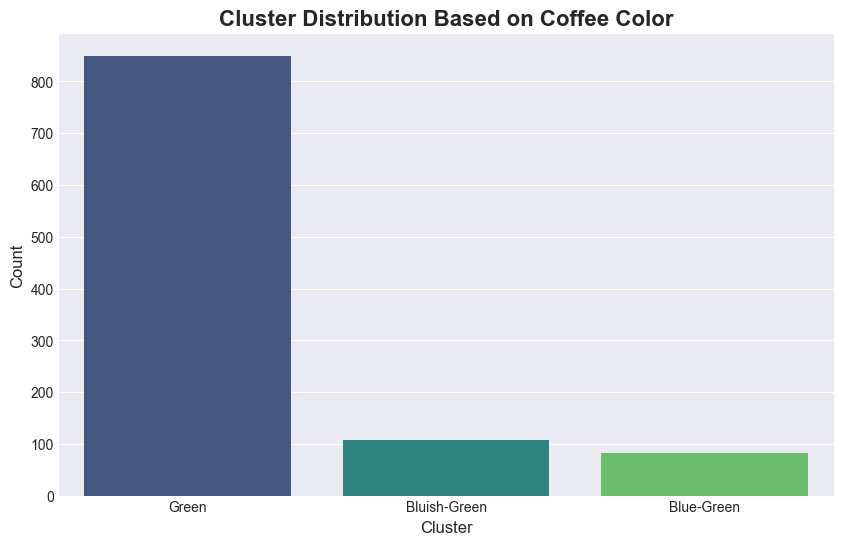

In [104]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Color', data=merged_df, palette='viridis')
plt.title('Cluster Distribution Based on Coffee Color', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

✓ Missing values in 'Color' predicted and filled.
✓ Total missing values remaining: 0


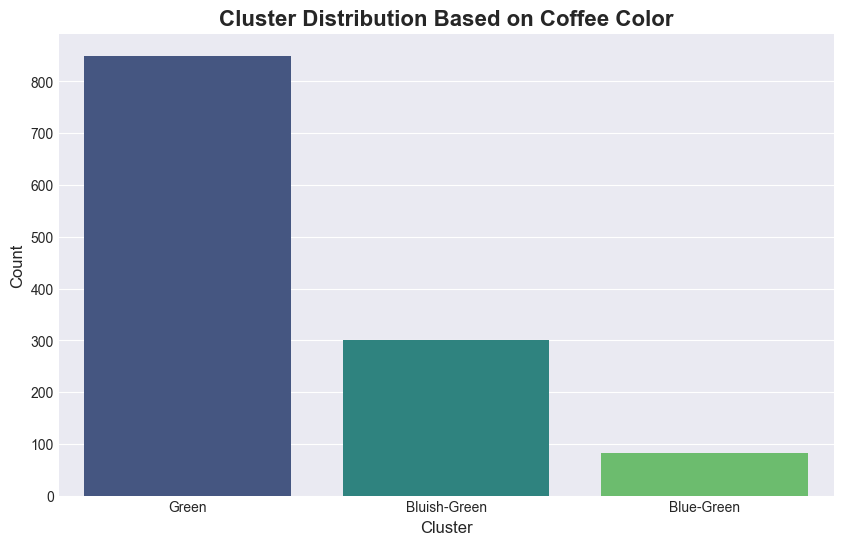

In [95]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Encode the 'Color' variable (excluding missing values)
label_encoder = LabelEncoder()
non_missing_colors = merged_df['Color'].dropna()
merged_df.loc[non_missing_colors.index, 'Color_encoded'] = label_encoder.fit_transform(non_missing_colors)

# Fill missing 'Color_encoded' values with a placeholder (e.g., -1) for clustering
merged_df['Color_encoded'] = merged_df['Color_encoded'].fillna(-1)

# Apply K-Means clustering only to predict missing values
missing_indices = merged_df[merged_df['Color'].isnull()].index
if len(missing_indices) > 0:
    kmeans = KMeans(n_clusters=3, random_state=42)
    # Fit K-Means on non-missing data
    kmeans.fit(merged_df.loc[non_missing_colors.index, ['Color_encoded']])
    # Predict clusters for missing values
    predicted_clusters = kmeans.predict(merged_df.loc[missing_indices, ['Color_encoded']])
    # Map predicted clusters back to original 'Color' categories
    predicted_colors = label_encoder.inverse_transform(predicted_clusters)
    merged_df.loc[missing_indices, 'Color'] = predicted_colors

print(f"✓ Missing values in 'Color' predicted and filled.")
print(f"✓ Total missing values remaining: {merged_df['Color'].isnull().sum()}")

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Color', data=merged_df, palette='viridis')
plt.title('Cluster Distribution Based on Coffee Color', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

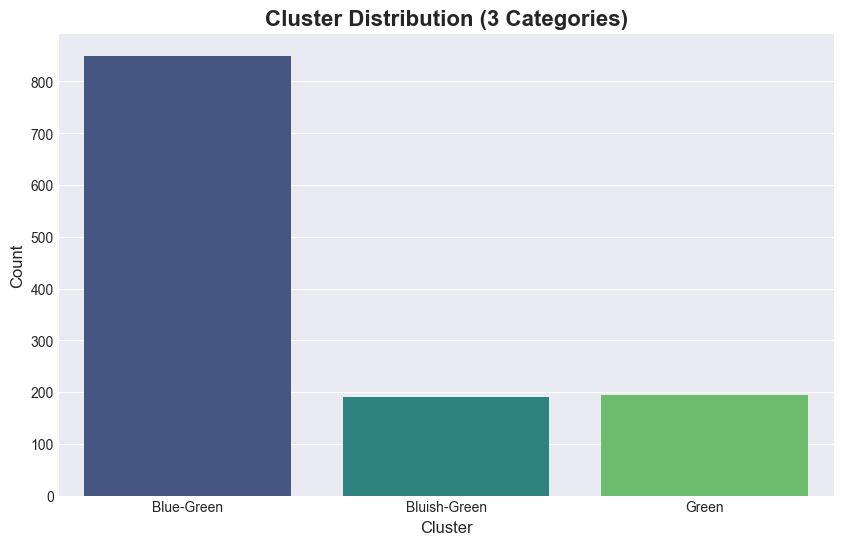

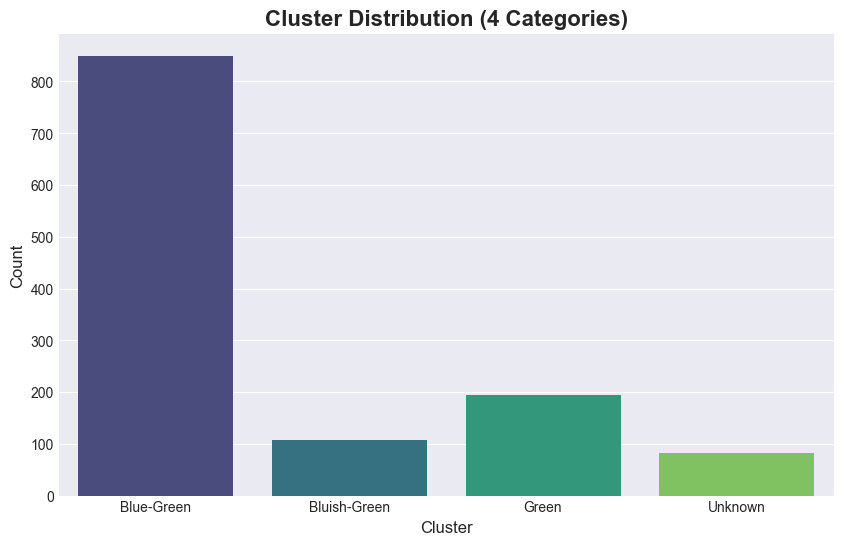

Cluster Centers (3 Categories): [[2.        ]
 [0.56315789]
 [3.        ]]
Cluster Centers (4 Categories): [[ 2.0000000e+00]
 [ 1.0000000e+00]
 [ 3.0000000e+00]
 [-4.4408921e-16]]


In [126]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

random_state = 2

# Replace NaN with 'Unknown' for testing
merged_df['Color'] = merged_df['Color'].fillna('Unknown')

# Encode the 'Color' variable (including 'Unknown')
label_encoder = LabelEncoder()
merged_df['Color_encoded'] = label_encoder.fit_transform(merged_df['Color'])

# Run KMeans with 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=random_state)
merged_df['Cluster_3'] = kmeans_3.fit_predict(merged_df[['Color_encoded']])

# Run KMeans with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=random_state)
merged_df['Cluster_4'] = kmeans_4.fit_predict(merged_df[['Color_encoded']])

merged_df['Cluster_3'] = label_encoder.inverse_transform(merged_df['Cluster_3'])
merged_df['Cluster_4'] = label_encoder.inverse_transform(merged_df['Cluster_4'])

# Visualize the clusters for 3 categories
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_3', data=merged_df, palette='viridis')
plt.title('Cluster Distribution (3 Categories)', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Visualize the clusters for 4 categories
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster_4', data=merged_df, palette='viridis')
plt.title('Cluster Distribution (4 Categories)', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Compare cluster centers
print("Cluster Centers (3 Categories):", kmeans_3.cluster_centers_)
print("Cluster Centers (4 Categories):", kmeans_4.cluster_centers_)

array(['Bluish-Green', 'Bluish-Green', 'Bluish-Green', ..., 'Blue-Green',
       'Blue-Green', 'Green'], shape=(1234,), dtype=object)

In [94]:
var = "Color"

total_rows = len(merged_df)
non_null = merged_df[var].notna().sum()
unique_values = merged_df[var].nunique()
missing_pct = (merged_df[var].isna().sum() / total_rows) * 100

print(f"\n📊 {var}:")
print(f"   • Valores no nulos: {non_null:,}")
print(f"   • Valores únicos: {unique_values:,}")
print(f"   • Missing: {missing_pct:.1f}%")
print(f"   • Ratio únicos/no-nulos: {unique_values/non_null:.2%}")

# Mostrar top 5 valores más comunes
print(f"   • Top 5 valores más frecuentes:")
top_values = merged_df[var].value_counts().head(5)
for idx, (value, count) in enumerate(top_values.items(), 1):
    print(f"      {idx}. {value}: {count} ({count/non_null*100:.1f}%)")


📊 Color:
   • Valores no nulos: 1,234
   • Valores únicos: 3
   • Missing: 0.0%
   • Ratio únicos/no-nulos: 0.24%
   • Top 5 valores más frecuentes:
      1. Green: 850 (68.9%)
      2. Bluish-Green: 301 (24.4%)
      3. Blue-Green: 83 (6.7%)


### 2.4 Resultados de la Limpieza

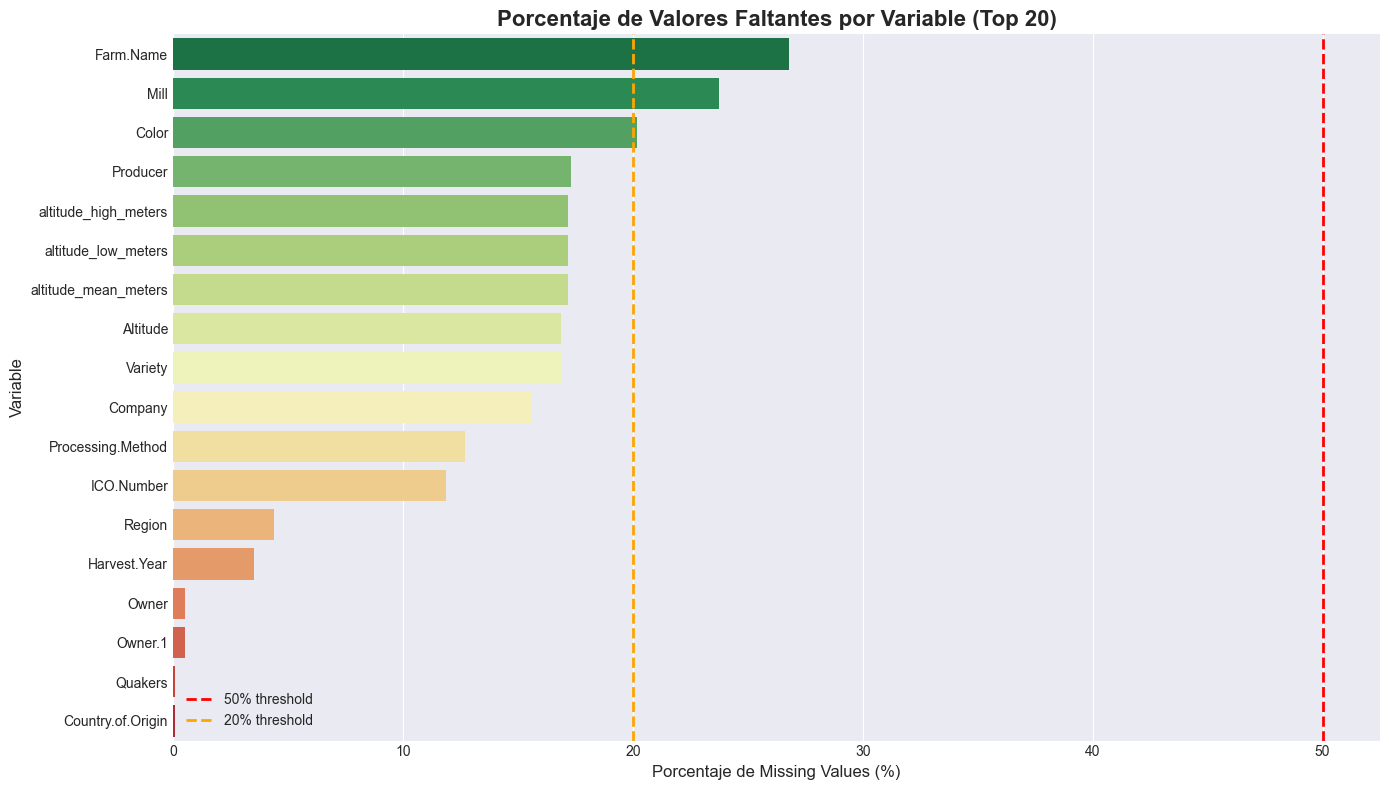

In [7]:
# Visualización de valores faltantes
missing_data = merged_df.isnull().sum()
missing_percent = (missing_data / len(merged_df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_data,
    'Porcentaje': missing_percent
}).sort_values(by='Porcentaje', ascending=False)


fig, ax = plt.subplots(figsize=(14, 8))
missing_plot = missing_df[missing_df['Valores Faltantes'] > 0].head(20)
sns.barplot(x='Porcentaje', y=missing_plot.index, data=missing_plot, ax=ax, palette='RdYlGn_r')
ax.axvline(50, color='red', linestyle='--', linewidth=2, label='50% threshold')
ax.axvline(20, color='orange', linestyle='--', linewidth=2, label='20% threshold')
ax.set_title('Porcentaje de Valores Faltantes por Variable (Top 20)', fontsize=16, fontweight='bold')
ax.set_xlabel('Porcentaje de Missing Values (%)', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
ax.legend()
plt.tight_layout()

# Crear directorio si no existe
output_path = project_root / 'reports' / 'figures'
output_path.mkdir(parents=True, exist_ok=True)

plt.savefig(project_root / 'reports' / 'figures' / 'missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()